<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/Project_5_SF_Scoring_Akimkin_Timofey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Загрузка библиотек

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Загрузка данных

In [8]:
# DATA_DIR = '/kaggle/input/sf-scoring/'
DATA_DIR = '/content/sample_data'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [9]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

===========================================================================================================================
# Первичный осмотр данных
===========================================================================================================================

In [10]:
# sample_submission.sample(5)

In [11]:
# sample_submission.shape

In [12]:
# sample_submission.info()

In [13]:
df_test.shape

(36349, 18)

===========================================================================================================================
# EDA
===========================================================================================================================

### Посмотрим распределение числовых признаков и их логарифмов

In [14]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

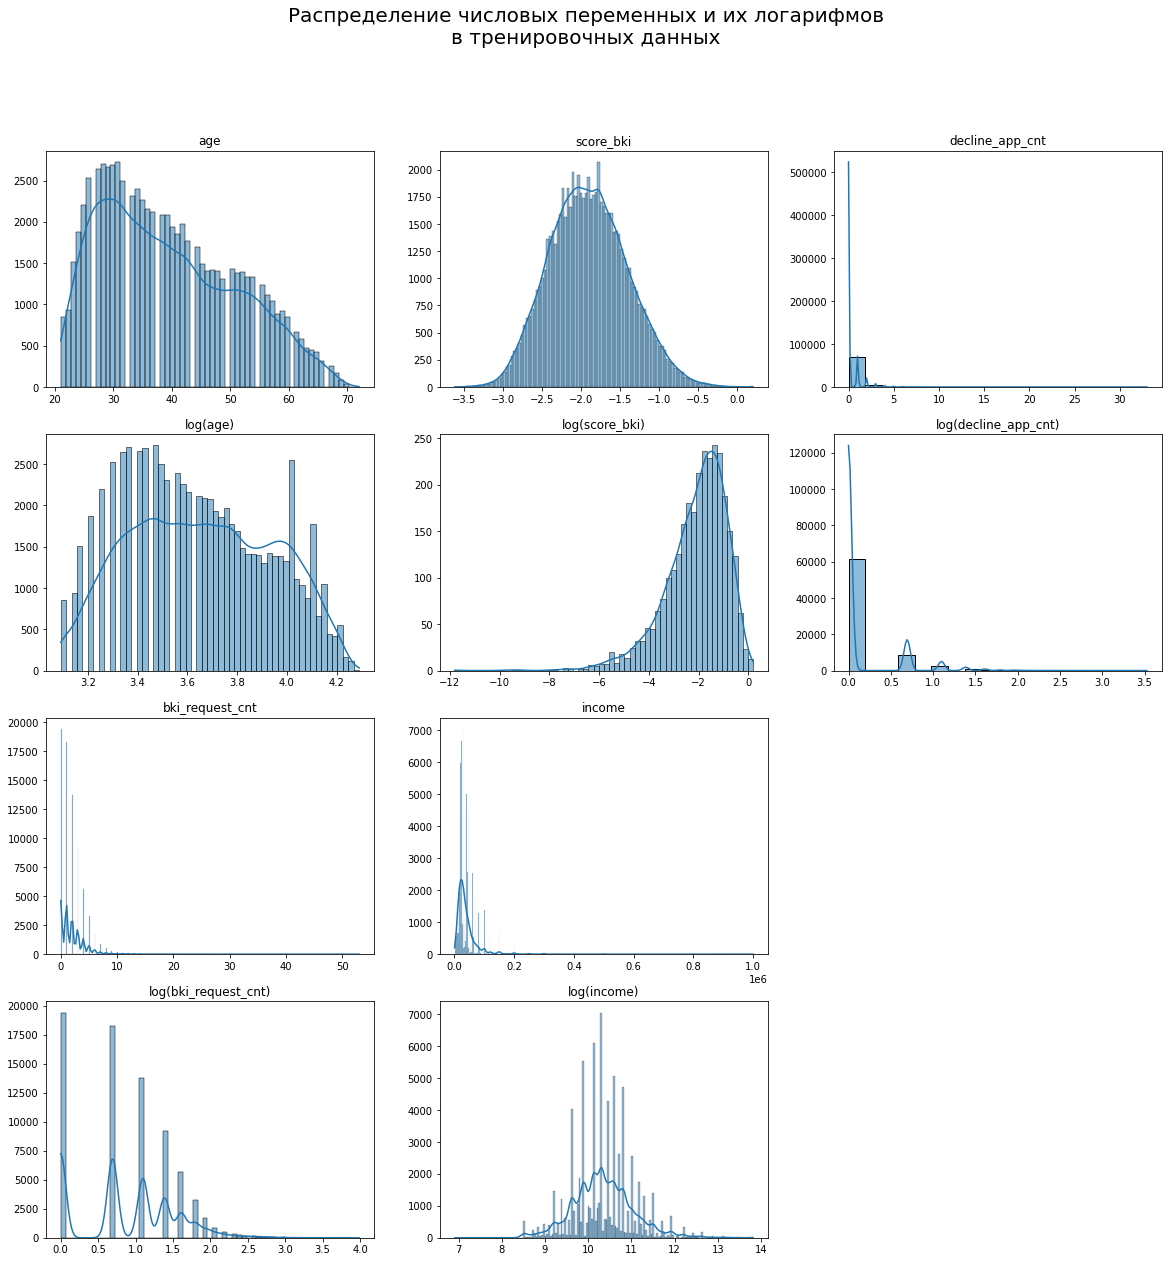

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

n_col_fig = 3
fig, ax = plt.subplots((len(num_cols) // n_col_fig + 1) * 2, n_col_fig, sharey=False, figsize=(20,20))
fig.suptitle('Распределение числовых переменных и их логарифмов\nв тренировочных данных', fontsize=20);

for i, cat in enumerate(num_cols):
    ax_curr = ax[2 * (i // 3), i % 3]    
    sns.histplot(df_train[cat].dropna(), kde=True, ax=ax_curr)
    ax_curr.set_title(cat)
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')

    ax_curr = ax[2 * (i // 3) + 1, i % 3]    
    sns.histplot(df_train[cat].apply(lambda x: np.log(x + 1)).dropna(), kde=True, ax=ax_curr)
    ax_curr.set_title(f'log({cat})')
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')
    
#  убираем пустые графики
for axes in ax.flatten():
    if not(axes.has_data()):
        fig.delaxes(axes)

In [23]:
def draw_charts_for_numeric(data, target='default', plot_type='histplot', charts_in_row=3, \
                title='Распределение числовых переменных и их логарифмов\n',\
                fs=(20,20),\
                **kwargs):
    
    def chart_to_plot(data_, col, tgt, plt_fun, ax_c, is_log=False):
        d = data_[[col, tgt]].dropna().copy()
        # d = data_.dropna().copy()
    
        if is_log:
            d[col] = d[col].apply(lambda x: np.log(x + 1))
            
        if plt_fun == 'histplot':
            sns.histplot(d[col], kde=True, ax=ax_c)
        elif plt_fun == 'boxplot':
            sns.boxplot(x=tgt, y=col, data=d, ax=ax_c)
            ax_c.set_xlabel(col, fontsize=13)
            
    n_feat_to_plot = data.shape[1] - 1

    fig, ax = plt.subplots((n_feat_to_plot // charts_in_row + 1) * 2, charts_in_row, sharey=False, figsize=fs)
    fig.suptitle(title, fontsize=20);

    for i, feat in enumerate(data.columns):
        
        ax_curr = ax[2 * (i // 3), i % 3]    
        
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, ax_c=ax_curr)
        
        ax_curr.set_title(feat)
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)
            
        ax_curr = ax[2 * (i // 3) + 1, i % 3]    
       
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, is_log=True, ax_c=ax_curr)
        
        ax_curr.set_title(f'log({feat})')
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)
        
    for axes in ax.flatten():
        if not(axes.has_data()):
            fig.delaxes(axes)

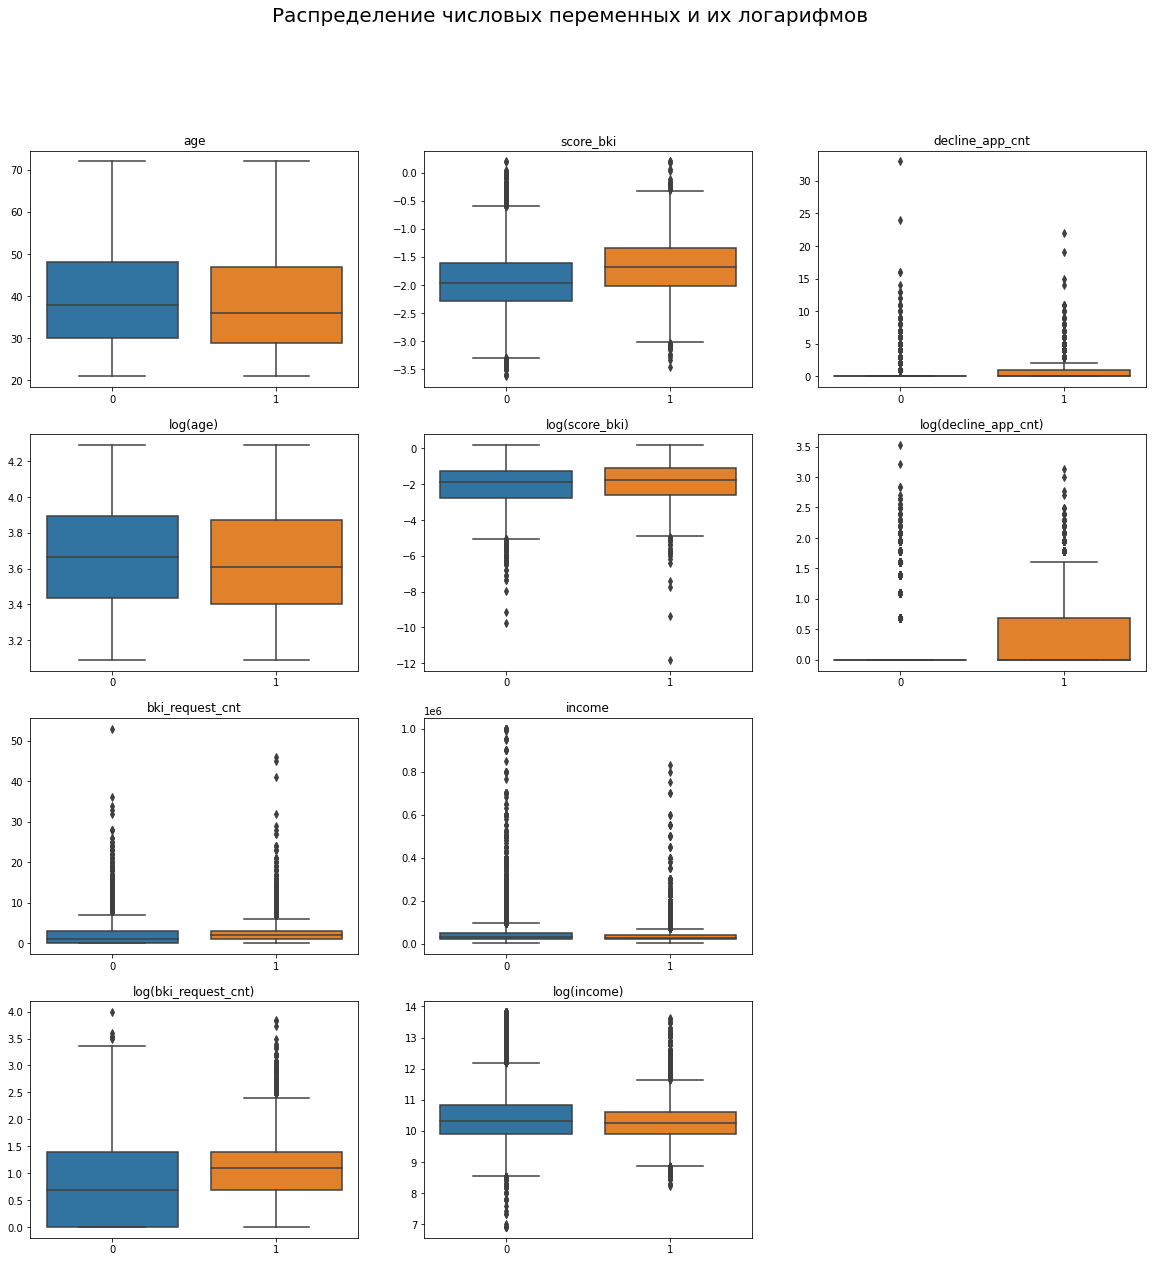

In [18]:
draw_charts_for_numeric(data=df_test[num_cols+['default']], plot_type='histplot', charts_in_row=3, \
                title='Распределение числовых переменных и их логарифмов\nв тестовых данных',\
                fs=(20,20))

draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='histplot', charts_in_row=3, \
                title='Распределение числовых переменных и их логарифмов\nв тренировочных данных',\
                fs=(20,20))

draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='boxplot', charts_in_row=3, \
                title='Распределение числовых переменных и их логарифмов\nв тренировочных данных',\
                fs=(20,20))

In [ ]:
# sns.boxplot(y='age', x='default', data=df_train[num_cols+['default']]);

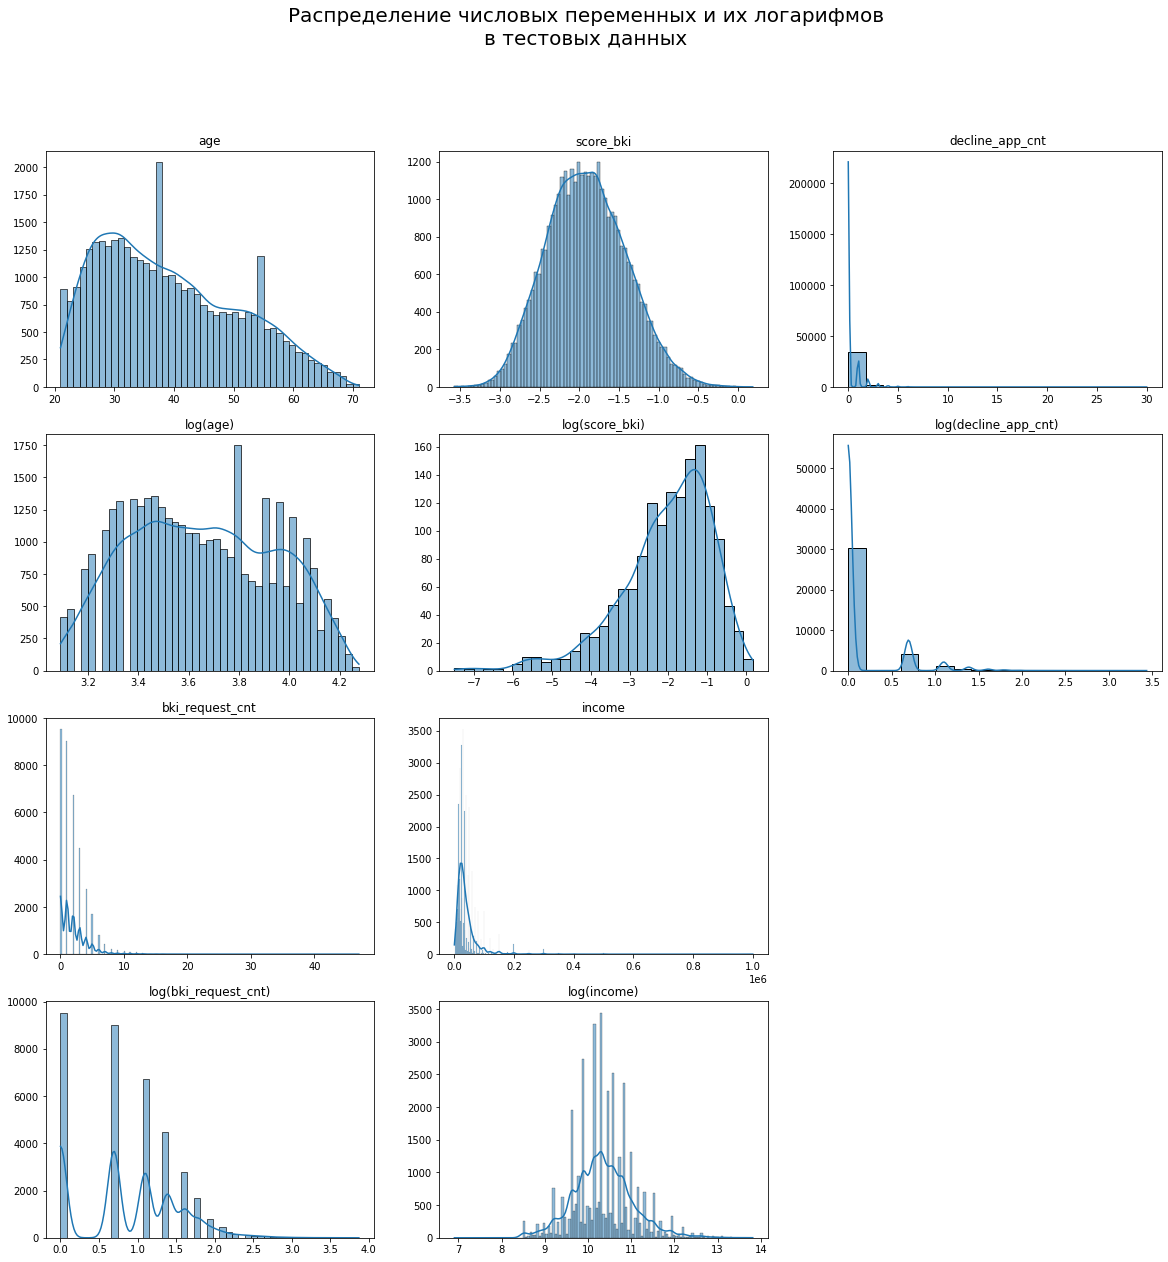

In [21]:
n_col_fig = 3
fig, ax = plt.subplots((len(num_cols) // n_col_fig + 1) * 2, n_col_fig, sharey=False, figsize=(20,20))
fig.suptitle('Распределение числовых переменных и их логарифмов\nв тестовых данных', fontsize=20);

for i, cat in enumerate(num_cols):
    ax_curr = ax[2* (i // 3), i % 3]    
    sns.histplot(df_test[cat].dropna(), kde=True, ax=ax_curr)
    ax_curr.set_title(cat)
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')

    ax_curr = ax[2*(i // 3) + 1, i % 3]    
    sns.histplot(df_test[cat].dropna().apply(lambda x: np.log(x + 1)), kde=True, ax=ax_curr)
    ax_curr.set_title(f'log({cat})')
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')
    
for axes in ax.flatten():
    if not(axes.has_data()):
        fig.delaxes(axes)

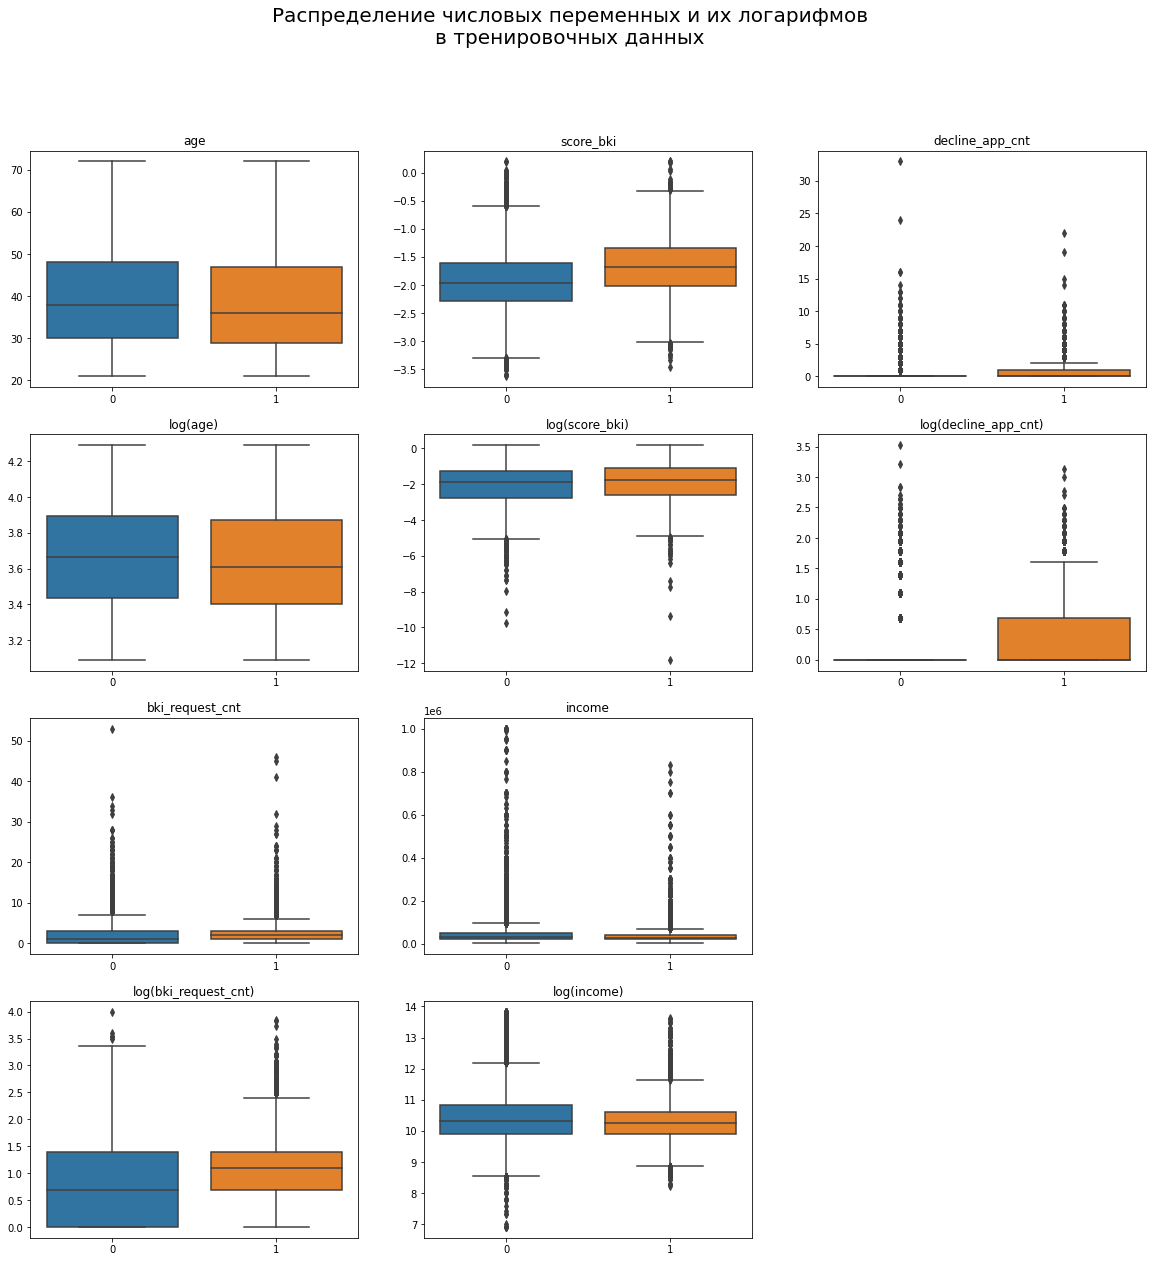

In [22]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
n_col_fig = 3
fig, ax = plt.subplots((len(num_cols) // n_col_fig + 1) * 2, n_col_fig, sharey=False, figsize=(20,20))
fig.suptitle('Распределение числовых переменных и их логарифмов\nв тренировочных данных', fontsize=20);

d = df_train[num_cols+['default']].dropna().copy()

for i, cat in enumerate(num_cols+['default']):
    
    ax_curr = ax[2* (i // 3), i % 3]    

    sns.boxplot(y=cat, x='default', data=d, ax=ax_curr)
    
    ax_curr.set_title(cat)
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')
    
    if cat=='default': fig.delaxes(ax_curr)

    ax_curr = ax[2*(i // 3) + 1, i % 3]    

    d[cat] = d[cat].apply(lambda x: np.log(x + 1))
    sns.boxplot(y=cat, x='default', data=d, ax=ax_curr)
    
    ax_curr.set_title(f'log({cat})')
    ax_curr.set_xlabel('')
    ax_curr.set_ylabel('')
    
    if cat=='default': fig.delaxes(ax_curr)
    
for axes in ax.flatten():
    if not(axes.has_data()):
        fig.delaxes(axes)

In [ ]:
# df_train.info()

In [ ]:
# df_test.info()

### есть пропуски в признаке education

In [ ]:
df_train.sample(5)

In [ ]:
pandas_profiling.ProfileReport(df_train.drop(['client_id'], axis=1))

In [ ]:
#для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем, где у нас тренировочные данные
df_test['sample'] = 0  # помечаем, где у нас тестовые данные
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train и test

In [ ]:
data.nunique(dropna=False)

In [ ]:
old_cols = set(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'])

new_cols = set(df_train.columns) - old_cols
new_cols

In [ ]:
data['default'].value_counts(ascending=True).plot(kind='barh');

In [ ]:
#заполняем пропуски в education случайным образом с распределением как в df_train 
edu_species = data['education'].dropna().unique()
edu_species_num = edu_species.shape[0]
weights = data[data['sample']==1]['education'].value_counts() / data[data['sample']==1]['education'].count()

data['education'] = data['education'].apply(
    lambda x: np.random.choice(edu_species, 1, p = weights)[0] if pd.isna(x) else x
)

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(3, 3, figsize=(20, 8))

for i, cat in enumerate(num_cols):
    ax_c = ax[i // 2, i % 2]
    sns.boxplot(x='default', y=cat, data=data[num_cols+['default']], ax=ax_c)
    ax_c.set_ylabel(cat, fontsize=13)
# ax2 = sns.boxenplot(x='', y='', data=data[])
fig.suptitle('Распределение числовых переменных', fontsize=16);

========================================================
###  ***поработать с признаком 'app_date'***

In [ ]:
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [ ]:
data = pd.get_dummies(data, columns=['education'], dummy_na=False)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [ ]:
data.info()

In [ ]:
data

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
test_data.columns

In [ ]:
X_train.columns

In [ ]:
X_valid.columns

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics as mt# инструменты для оценки точности модели

In [ ]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000)

In [ ]:
logreg.fit(X_train, y_train)
y_proba = logreg.predict_proba(X_valid)[:, 1]

In [ ]:
import matplotlib.pyplot as plt

roc_auc = mt.roc_auc_score(y_valid, y_proba)
fpr, tpr, thrs = mt.roc_curve(y_valid, y_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title(f'Logistic Regression ROC AUC =  {roc_auc:0.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
predict_submission = logreg.predict(test_data)

# Submission

In [ ]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

In [ ]:
# !kaggle competitions submit Timofey Akimkin -c sf-scoring -f submission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'